<a href="https://colab.research.google.com/github/nh0875/Desafios-Procesamiento-del-Habla-974/blob/main/Desafio_Clustering_Hilliard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Presentacion y Descripcion del DataSet**

El data set tiene datos sobre olores de 20 perfumes distintos, los datos fueron obtenidos usando un sensor que media la intensidad del olor que tenia el perfume, es un dataset de 29x20, investigue sobre como funcionan los sensores para medir olores (OMX-GR) y como valor maximo pueden devolver 90 y como minimo 0, todo el dataset esta compuesto por valores entre los recien mencionados

https://archive.ics.uci.edu/dataset/303/perfume+data

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.stats import mode
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import random

df = pd.read_excel('/content/perfume_data.xlsx')
df.columns = df.columns.astype(str)
df = pd.get_dummies(df, drop_first=True)
print (df.to_string())
df.dtypes

        1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28  Perfume_TeaTreeOil  Perfume_ajayeb  Perfume_ajmal  Perfume_amreaj  Perfume_aood  Perfume_asgar_ali  Perfume_bukhoor  Perfume_burberrry  Perfume_carolina_herrera  Perfume_constrected  Perfume_constrected2  Perfume_dehenalaod  Perfume_junaid  Perfume_kausar  Perfume_oudh_ma'alattar  Perfume_raspberry  Perfume_rose  Perfume_solidmusk  Perfume_strawberry
0   64558  64556  64543  64543  64541  64543  64543  64541  64541  64541  64541  64541  64541  64528  64528  63529  63529  64541  64541  64541  64541  64541  64541  64541  64528  64528  64528  64528               False            True          False           False         False              False            False              False                     False                False                 False               False           False        

,0
1,int64
2,int64
3,int64
4,int64
5,int64
6,int64
7,int64
8,int64
9,int64
10,int64


# **Preprocesamiento del Dataset**
1° Identifico y valores nulos

2° Eliminar Outliners

3° Estandarizar los Datos

4° Separar los datasets para mis dos modelos


In [81]:
# Verifico si el dataset posee valores nulos
print(df.isnull().sum().sum())

0


In [82]:
#Elimino los outliners
def remove_outliers(df):
    numeric_df = df.select_dtypes(include=np.number)
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_out
df = remove_outliers(df)
#Estandarizo los datos
scaler = StandardScaler()
numeric_features = df.select_dtypes(include=np.number).columns
df[numeric_features] = scaler.fit_transform(df[numeric_features])


<ipython-input-82-3f07cca41a7b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_features] = scaler.fit_transform(df[numeric_features])


# **Evaluacion**
**Voy a usar silhouette para encontrar la cantidad ideal de clusters para mis modelo de K-means, mientras que el otro lo elegira un modelo de Aprendizaje por Refuerzo, es decir ira cambiando la cantidad de clusters por episodio basandose en el indice de Silueta el cual mientras mas alto sea mayor sera la recompensa que reciira el modelo**    

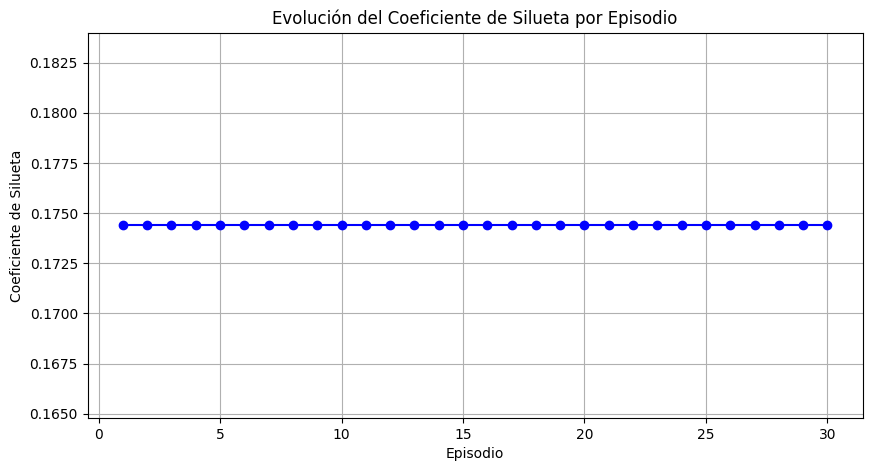

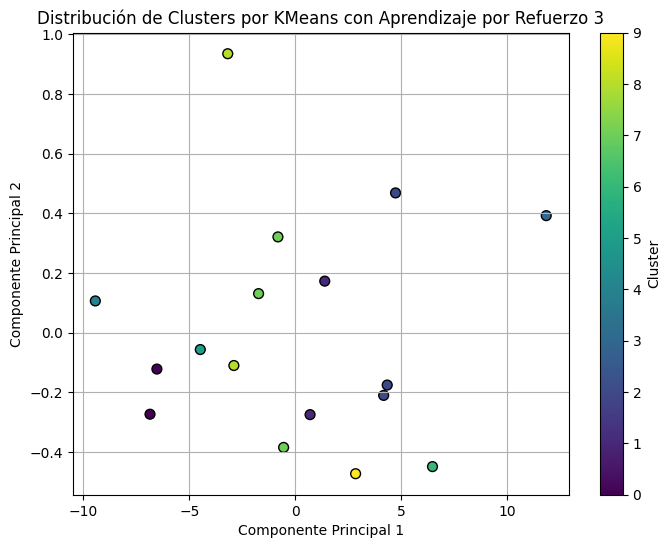

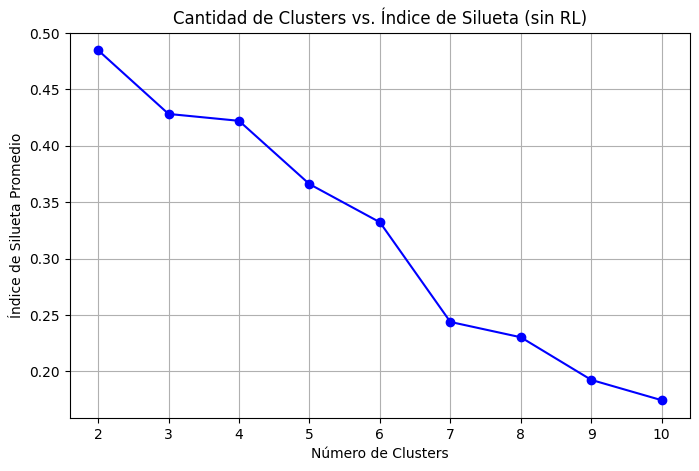

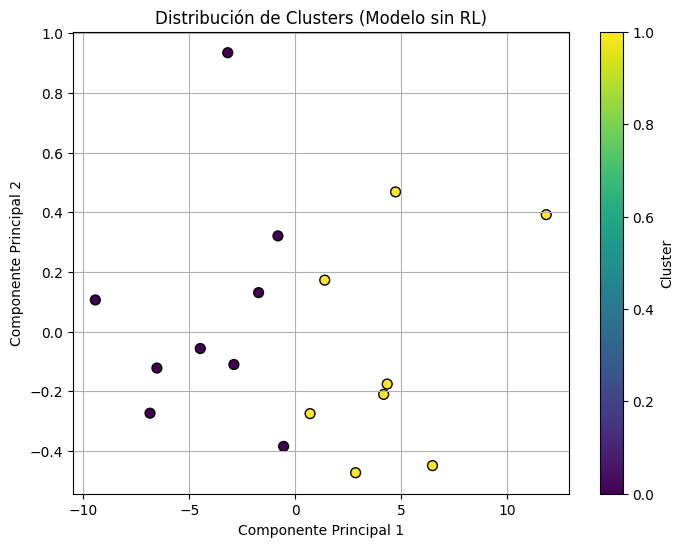

In [110]:
range_n_clusters = range(2, 11)
silhouette_avg = []

# Proceso de K-means con diferentes cantidades de clusters y cálculo del índice de silueta
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg.append(silhouette_score(df, cluster_labels))

# Gráfico de la distribución de clusters para el número de clusters sin RL
kmeans_non_rl = KMeans(n_clusters=2, random_state=42)
y_pred_non_rl = kmeans_non_rl.fit_predict(df)

# Definimos los parámetros del modelo de aprendizaje por refuerzo
max_clusters = 10
min_clusters = 2
n_episodes = 30

epsilon = 0.1
gamma = 0.9
best_n_clusters = min_clusters
best_silhouette_score = -1
silhouette_scores = []

# Algoritmo de Aprendizaje por Refuerzo para ajustar el número de clusters
for episode in range(n_episodes):
    if random.uniform(0, 1) < epsilon:
        action = random.choice([-1, 1])
    else:
        action = 1 if best_n_clusters < max_clusters else -1
    n_clusters = best_n_clusters + action
    if n_clusters < min_clusters:
        n_clusters = min_clusters
    elif n_clusters > max_clusters:
        n_clusters = max_clusters
    kmeans_RL = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    current_silhouette_score = silhouette_score(df, cluster_labels)

    # Actualizamos el mejor número de clusters si se obtiene una mejor recompensa
    if current_silhouette_score > best_silhouette_score:
        best_n_clusters = n_clusters
        best_silhouette_score = current_silhouette_score

    silhouette_scores.append(best_silhouette_score)


# Gráfico de la distribución de clusters para el número óptimo de clusters
kmeans_RL = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans_RL.fit(df)
y_pred_kmeans = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

#Graficos del Modelo de Clustering con RL
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_episodes + 1), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Evolución del Coeficiente de Silueta por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Coeficiente de Silueta")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_kmeans, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title(f"Distribución de Clusters por KMeans con Aprendizaje por Refuerzo {best_n_clusters}")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_avg, marker='o', linestyle='-', color='b')
plt.title("Cantidad de Clusters vs. Índice de Silueta (sin RL)")
plt.xlabel("Número de Clusters")
plt.ylabel("Índice de Silueta Promedio")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_non_rl, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("Distribución de Clusters (Modelo sin RL)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


# **Conclusion Final**
El modelo con aprendizaje por refuerzo se comportó de una manera particular señalando un número ideal de clusters de tres me llamó la atención que lo hiciera ya que tranquilamente podría haber elegido dos viendo la gráfica de evolución del coeficiente de silueta por episodio,   creo que cometí un error al elegir un dataset con tan pocos datos,  por lo que entiendo debería haber elegido un dataset con más cantidad de datos cosa de poder representar mejor mis métricas como también mi agrupamiento